In [1]:
import os
import random
import collections

import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import skimage
from skimage import exposure, img_as_float
#plt.style.use('dark_background')
#plt.style.use('seaborn-deep')
plt.style.use('Solarize_Light2')
%matplotlib inline

In [2]:
print(plt.style.available)

['seaborn-bright', 'tableau-colorblind10', 'seaborn-dark-palette', 'seaborn-notebook', 'seaborn-muted', 'fivethirtyeight', 'seaborn-talk', 'seaborn-deep', 'grayscale', '_classic_test', 'seaborn', 'seaborn-colorblind', 'bmh', 'seaborn-pastel', 'seaborn-whitegrid', 'classic', 'Solarize_Light2', 'seaborn-darkgrid', 'seaborn-paper', 'seaborn-dark', 'dark_background', 'seaborn-ticks', 'fast', 'seaborn-poster', 'seaborn-white', 'ggplot']


In [3]:
IMAGE_DIMENSIONS_NUM = 3
images_dir = '../input/train'
train_images_description_file_path = '../input/train.csv'
full_cwd_path = os.getcwd()
path_prefix, cwd_itself = os.path.split(full_cwd_path)
if cwd_itself != 'code':
    os.chdir(os.path.join(path_prefix, 'code'))
    print(os.getcwd())

In [4]:
train_images_names = os.listdir(images_dir)

In [5]:
#len(train_images_names)
print("train_images_names len: {}".format(len(train_images_names)))
#print("train_images_masks_names len: {}".format(len(train_images_masks_names)))
print(train_images_names[:10]) # Is an image name and mask name with the same index matd_df = pd.read_csv(segmentation_file_path)
#print(train_images_masks_names[:10])
train_images_description_df = pd.read_csv(train_images_description_file_path)
print(train_images_description_df.head())
print(train_images_description_df.shape)

train_images_names len: 25361
['4fa457dc6.jpg', '47a1e0a6e.jpg', 'f1484122e.jpg', '534284730.jpg', '8d7319156.jpg', 'bf06deacf.jpg', 'cf43c77e8.jpg', 'a0611b54a.jpg', 'efb089722.jpg', 'f20d6c29e.jpg']
           Image         Id
0  0000e88ab.jpg  w_f48451c
1  0001f9222.jpg  w_c3d896a
2  00029d126.jpg  w_20df2c5
3  00050a15a.jpg  new_whale
4  0005c1ef8.jpg  new_whale
(25361, 2)


In [6]:
train_images_description_df.describe()

,Image,Id
count,25361,25361
unique,25361,5005
top,a51bc88fd.jpg,new_whale
freq,1,9664


In [7]:
train_images_description_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25361 entries, 0 to 25360
Data columns (total 2 columns):
Image    25361 non-null object
Id       25361 non-null object
dtypes: object(2)
memory usage: 396.3+ KB


In [8]:
train_images_description_df['Id'].unique().shape

(5005,)

In [97]:
print(train_images_description_df['Id'].unique())

['w_f48451c' 'w_c3d896a' 'w_20df2c5' ... 'w_2807565' 'w_17a108a'
 'w_9f30885']


In [10]:
def select_objects(indexes_list, objects_names):
    return tuple(objects_names[i] for i in indexes_list)

In [11]:
def select_random_indexses_subset(size, subset_size):
    return random.sample(tuple(range(size)), subset_size)

In [12]:
def random_objects_select(objects_names, subset_size):
    objects_names_len = len(objects_names)
    indexes = select_random_indexses_subset(objects_names_len, subset_size)
    return select_objects(indexes, objects_names)

In [13]:
def select_offset_indexses_subset(size, subset_size, offset):
    return tuple(range(size))[offset:offset + subset_size]

In [14]:
def offset_objects_select(objects_names, subset_size, offset):
    objects_names_len = len(objects_names)
    indexes = select_offset_indexses_subset(objects_names_len, subset_size, offset)
    return select_objects(indexes, objects_names)

In [15]:
def show_images_grid(images_list, columns_num, figsize, images_names_list=None):
    rows_num = len(images_list) // columns_num
    fig, ax = plt.subplots(rows_num, columns_num, figsize=figsize)
    images_list_len = len(images_list)
    slice_len = columns_num
    images_list_slices_len = images_list_len // slice_len
    images_names_list_slices = []
    images_list_slices = [
        images_list[i * slice_len:(i+1) * slice_len]\
        for i in range(images_list_slices_len)
    ]
    if images_names_list:
        images_names_list_slices = [
            images_names_list[i * slice_len:(i+1) * slice_len]\
            for i in range(images_list_slices_len)
        ]
    #print("show_images_grid, images_names_list_slices:\n", images_names_list_slices)
    for i in range(ax.shape[0]):
        images_list_slice = images_list_slices[i]
        images_names_list_slice = []
        if images_names_list:
            images_names_list_slice = images_names_list_slices[i]
        #images_list_0 = [images_pair[0] for images_pair in paired_images_list_slice]
        #images_list_1 = [images_pair[1] for images_pair in paired_images_list_slice]
        for j in range(columns_num):
            if images_names_list:
                #print("show_images_grid, images_names_list_slice[{}]:\n".format(j), images_names_list_slice[j])
                ax[i, j].set_title(images_names_list_slice[j])            
            ax[i, j].imshow(images_list_slice[j])

            #ax[2 * i + 1, j].imshow(images_list_1[j])
    plt.tight_layout()
    plt.show()

In [16]:
def draw_images_with_histograms(images_list, columns_num, figsize, nbins):
    rows_num = 3 * len(images_list) // columns_num
    fig, ax = plt.subplots(rows_num, columns_num, figsize=figsize)
    images_list_len = len(images_list)
    slice_len = columns_num
    images_list_slices_len = images_list_len // slice_len
    images_list_slices = [
    images_list[i * slice_len:(i+1) * slice_len]\
        for i in range(images_list_slices_len)
    ]
    for i in range(ax.shape[0] // 3):
        images_list_slice = images_list_slices[i]
        for j in range(columns_num):
            ax[3 * i, j].imshow(images_list_slice[j])
            ax[3 * i, j].grid(False)
            img_cdf, cdf_bins = exposure.cumulative_distribution(images_list_slice[j].flatten())
            ax[3 * i + 1, j].hist(exposure.histogram(images_list_slice[j].flatten(), nbins=nbins))
            ax[3 * i + 2, j].plot(cdf_bins, img_cdf, color='green')
    plt.show()

In [17]:
def extract_object_pixels_by_mask(image, mask):
    return image * mask
apply_mask_to_color_channel = extract_object_pixels_by_mask

In [18]:
def extract_not_object_pixels_by_mask(image, mask):
    #return image * (np.ones(mask.shape) - mask)
    not_object_pixels = image * (np.ones(mask.shape) - mask)
    #print("extract_non_salt_pixels_by_mask:\n", non_salt_pixels)
    return not_object_pixels
apply_negative_mask_to_color_channel = extract_not_object_pixels_by_mask

In [19]:
def get_mask_complement(mask):
    return np.ones(mask.shape) - mask

In [20]:
def compute_object_pixels_num(mask):
    return mask.sum()

def compute_not_object_pixels_num(mask):
    return mask.size - mask.sum()

In [21]:
def compute_whole_image_mean_brightnes(image):
    return image.mean()

In [22]:
def compute_color_channel_mean_brightness(color_channel):
    return color_channel.mean()

In [23]:
def compute_color_channels_mean_brightness(color_channels):
    return [
        compute_color_channel_mean_brightness(color_channel) for color_channel in color_channels
    ]

In [24]:
def compute_images_list_color_channels_mean_brightness(images_color_channels_list):
    return [
        compute_color_channels_mean_brightness(
            image_color_channels
        ) for image_color_channels in images_color_channels_list
    ]

In [25]:
def divide_color_channels_values(color_channels_values):
    return (
        [color_channel_value[0] for color_channel_value in color_channels_values],
        [color_channel_value[1] for color_channel_value in color_channels_values],
        [color_channel_value[2] for color_channel_value in color_channels_values],
    )


In [26]:
def compute_object_pixels_mean_brightness(image, mask):
    full_color_image_salt_pixels = apply_mask_to_full_color_image(image, mask)
    #print(compute_salt_pixels_num(mask))
    salt_pixels_num = compute_salt_pixels_num(mask) * IMAGE_DIMENSIONS_NUM
    salt_pixels_sum = full_color_image_salt_pixels.sum()
    return 0.0 if salt_pixels_num == 0 else salt_pixels_sum / salt_pixels_num

In [27]:
def get_image_color_channels(image):
    return [image[:, :, i] for i in range(IMAGE_DIMENSIONS_NUM)]

def collapse_color_channels_to_image(color_components):
    return np.array([color_components[i].T for i in range(IMAGE_DIMENSIONS_NUM)]).T

In [28]:
def get_images_color_channels(images):
    return [get_image_color_channels(image) for image in images]

In [29]:
def apply_mask_to_color_channels(color_channels, mask):
    return [apply_mask_to_color_channel(color_channel, mask) for color_channel in color_channels]

In [30]:
def apply_negative_mask_to_color_channels(color_channels, mask):
    #print("apply_negative_mask_to_color_channels, color_channels:\n", color_channels)
    return [apply_negative_mask_to_color_channel(color_channel, mask) for color_channel in color_channels]

In [31]:
def apply_mask_to_full_color_image(image, mask):
    color_channels = get_image_color_channels(image)
    masked_color_channels = apply_mask_to_color_channels(
        color_channels,
        mask
    )
    return collapse_color_channels_to_image(masked_color_channels)

In [32]:
def apply_negative_mask_to_full_color_image(image, mask):
    color_channels = get_image_color_channels(image)
    masked_color_channels = apply_negative_mask_to_color_channels(
        color_channels,
        mask
    )
    return collapse_color_channels_to_image(masked_color_channels)

In [33]:
def calculate_mode(sample):
    flatten_sample = sample.flatten()
    counter = collections.Counter(sample.flatten())
    most_common = counter.most_common()
    if len(most_common) > 0:
        if len(most_common) == 1:
            return most_common[0]
        else:
            if most_common[0][0] == 0:
                return most_common[1]
            else:
                return most_common[0]
    else:
        return None
compute_color_channel_mode = calculate_mode

In [34]:
def collect_modes_and_frequencies(modes):
    modes_frequencies_dict = {}
    print("collect_modes_and_frequencies,  modes:\n", modes)
    for color_channels_modes in modes:
        mode_value, frequency = color_channels_modes[0]
        if mode_value in modes_frequencies_dict:
            modes_frequencies_dict[mode_value] += frequency
        else:
            modes_frequencies_dict[mode_value] = frequency
    return modes_frequencies_dict

In [35]:
def gather_color_channel_modes_and_frequencies(modes):
    modes_frequencies_dict = {}
    for color_channels_modes in modes:
        mode_value, frequency = color_channels_modes
        if mode_value in modes_frequencies_dict:
            modes_frequencies_dict[mode_value] += frequency
        else:
            modes_frequencies_dict[mode_value] = frequency
    return modes_frequencies_dict

In [36]:
def gather_objects_and_frequencies(objects_list):
    return collections.Counter(objects_list)

In [37]:
def gather_objects_and_frequencies(objects_list):
    frequencies_dict = {}
    for obj in objects_list:
        if obj in frequencies_dict:
            frequencies_dict[obj] += 1
        else:
            frequencies_dict[obj] = 1
    return frequencies_dict

In [38]:
def sort_gathered_objects(objects):
    objects_sorted = sorted(objects)
    objects_frequencies_sorted = []
    for obj in objects_sorted:
        objects_frequencies_sorted.append(objects[obj])
    return objects_sorted, objects_frequencies_sorted

In [39]:
def compute_color_channels_modes(color_channels):
    return [compute_color_channel_mode(color_channel) for color_channel in color_channels]

In [40]:
def compute_images_color_channels_modes(images_color_channels):
    return [
        compute_color_channels_modes(image_color_channels)\
        for image_color_channels in images_color_channels
    ]

In [41]:
def get_image_pixels(color_channels):
    return [
        (channel0value, channel1value, channel2value) for channel0value, channel1value, channel2value
           in zip(color_channels[0], color_channels[1], color_channels[2])
    ]

In [42]:
def get_image_pixels(image):
    color_channel0 = image[:, :, 0].ravel()
    color_channel1 = image[:, :, 1].ravel()
    color_channel2 = image[:, :, 2].ravel()
    return [(x, y, z) for x, y, z in zip(color_channel0, color_channel1, color_channel2)]

In [43]:
def compare_color_channels_by_pixels(image):
    image_pixels = get_image_pixels(image)
    return [compare_pixel_color_channels_values(pixel) for pixel in image_pixels]

In [44]:
def compare_images_color_channels(images):
    return [compare_color_channels_by_pixels(image) for image in images]

In [45]:
whales_train_images_num = train_images_description_df.shape[0]
whales_train_images_names_sample = random_objects_select(train_images_names, int(whales_train_images_num / 4))

In [46]:
'''
whales_train_images = [
    mpimg.imread(os.path.join(images_dir, image_name)) for image_name in whales_train_images_names_sample
]
'''
whales_train_images = [
    mpimg.imread(os.path.join(images_dir, image_name)) for image_name in train_images_names
]

In [89]:
print(len(whales_train_images))

25361


In [73]:
print("whales_train_images[0].shape: ", whales_train_images[0].shape)

whales_train_images[0].shape:  (631, 1050, 3)


In [74]:
whales_train_images[0]

array([[[ 60,  98, 135],
        [ 59,  97, 134],
        [ 53,  91, 128],
        ...,
        [132, 130, 151],
        [131, 129, 151],
        [130, 128, 150]],

       [[ 61,  99, 136],
        [ 61,  99, 136],
        [ 57,  95, 132],
        ...,
        [134, 132, 153],
        [135, 133, 154],
        [135, 133, 154]],

       [[ 58,  96, 133],
        [ 59,  97, 134],
        [ 57,  95, 132],
        ...,
        [140, 139, 157],
        [138, 136, 157],
        [138, 136, 157]],

       ...,

       [[  3,  52,  66],
        [  4,  53,  67],
        [  6,  55,  69],
        ...,
        [ 61, 107, 141],
        [ 63, 107, 142],
        [ 64, 108, 143]],

       [[  0,  50,  61],
        [  0,  52,  63],
        [  2,  54,  65],
        ...,
        [ 47,  96, 128],
        [ 47,  96, 128],
        [ 50,  99, 132]],

       [[  0,  50,  61],
        [  1,  53,  64],
        [  2,  54,  65],
        ...,
        [ 42,  93, 124],
        [ 41,  92, 123],
        [ 45,  96, 127]]

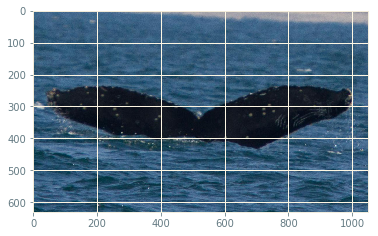

In [75]:
plt.imshow(whales_train_images[0])
plt.show()

In [76]:
print("whales_train_images[3471].shape: ", whales_train_images[3471].shape)

whales_train_images[3471].shape:  (667, 1000, 3)


In [77]:
whales_train_images[3471]

array([[[ 67,  98, 145],
        [ 66,  96, 146],
        [ 63,  95, 144],
        ...,
        [ 78, 115, 168],
        [ 75, 112, 165],
        [ 73, 110, 163]],

       [[ 97, 129, 176],
        [ 91, 123, 170],
        [ 82, 116, 162],
        ...,
        [101, 141, 192],
        [ 93, 133, 184],
        [ 87, 127, 178]],

       [[108, 145, 190],
        [ 99, 136, 181],
        [ 90, 127, 172],
        ...,
        [102, 145, 190],
        [101, 142, 188],
        [100, 141, 187]],

       ...,

       [[ 94, 132, 179],
        [ 93, 131, 178],
        [ 93, 131, 178],
        ...,
        [ 25,  61,  93],
        [ 24,  60,  92],
        [ 23,  59,  91]],

       [[ 88, 126, 173],
        [ 88, 126, 173],
        [ 90, 128, 175],
        ...,
        [ 21,  60,  91],
        [ 20,  59,  90],
        [ 18,  57,  88]],

       [[106, 144, 191],
        [105, 143, 190],
        [105, 143, 190],
        ...,
        [ 20,  61,  93],
        [ 18,  59,  91],
        [ 16,  57,  89]]

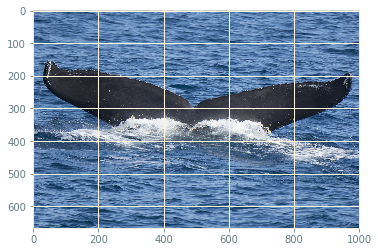

In [78]:

plt.imshow(whales_train_images[3471])
plt.show()

In [79]:
whales_images_subsample = whales_train_images[:40]

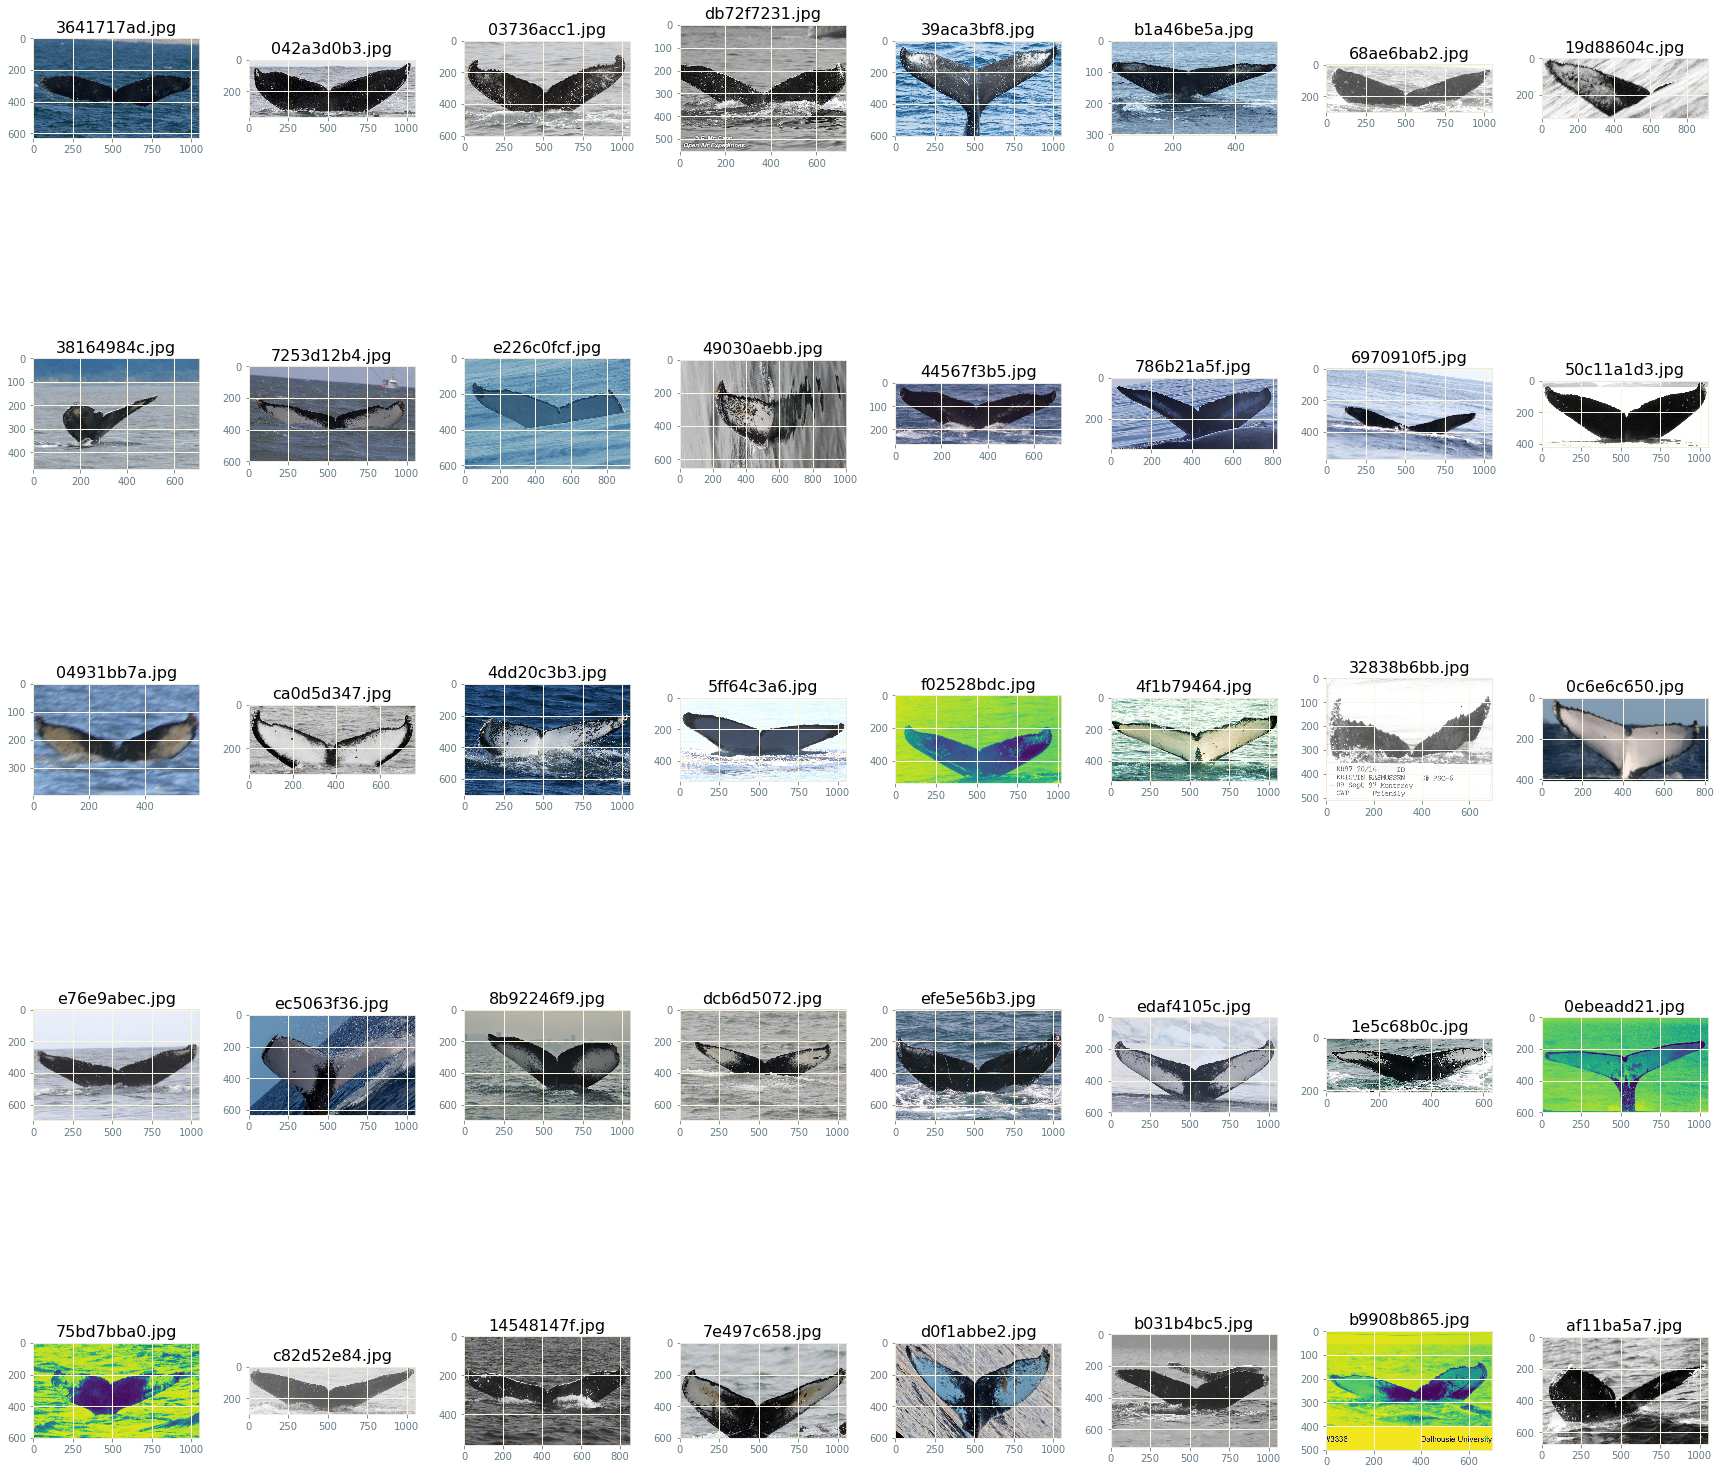

In [80]:
show_images_grid(whales_images_subsample, 8, (24, 24), images_names_list=whales_train_images_names_sample[:40])

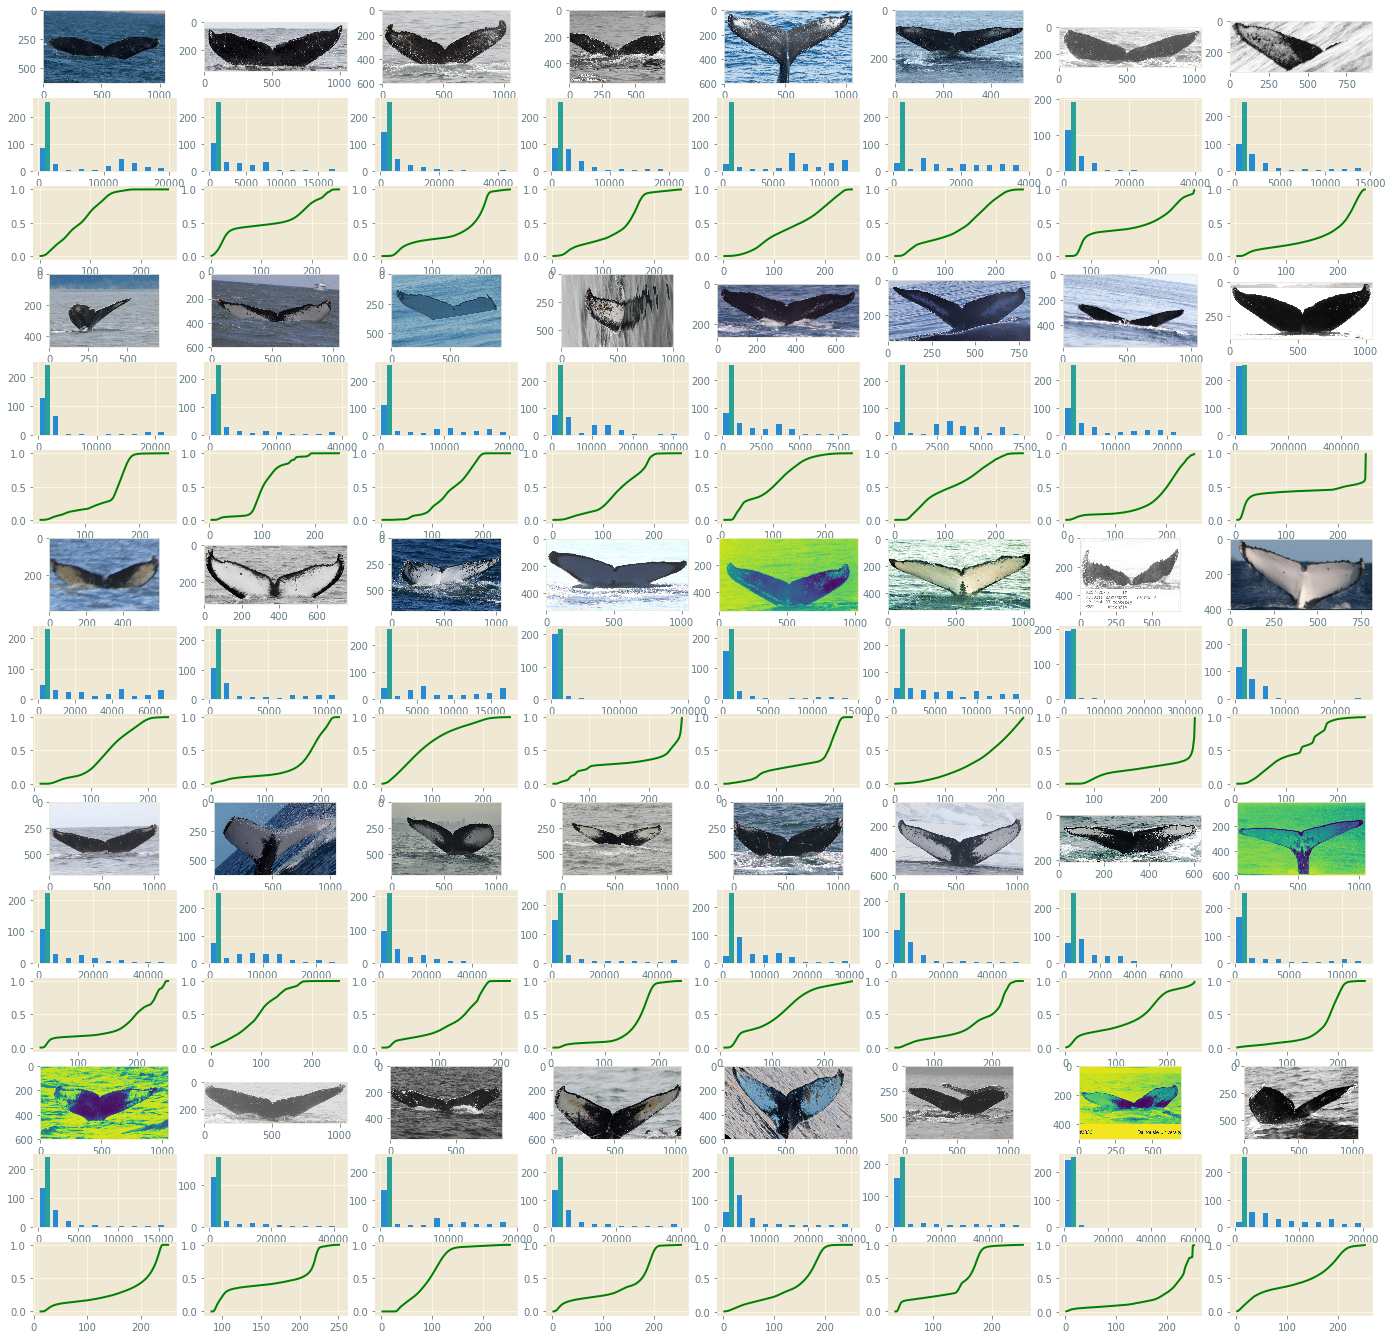

In [81]:
draw_images_with_histograms(whales_images_subsample[:40], 8, (24, 24), 20)

In [82]:
whales_train_images_mean_brightness = [
    compute_whole_image_mean_brightnes(image) for image in whales_train_images
]

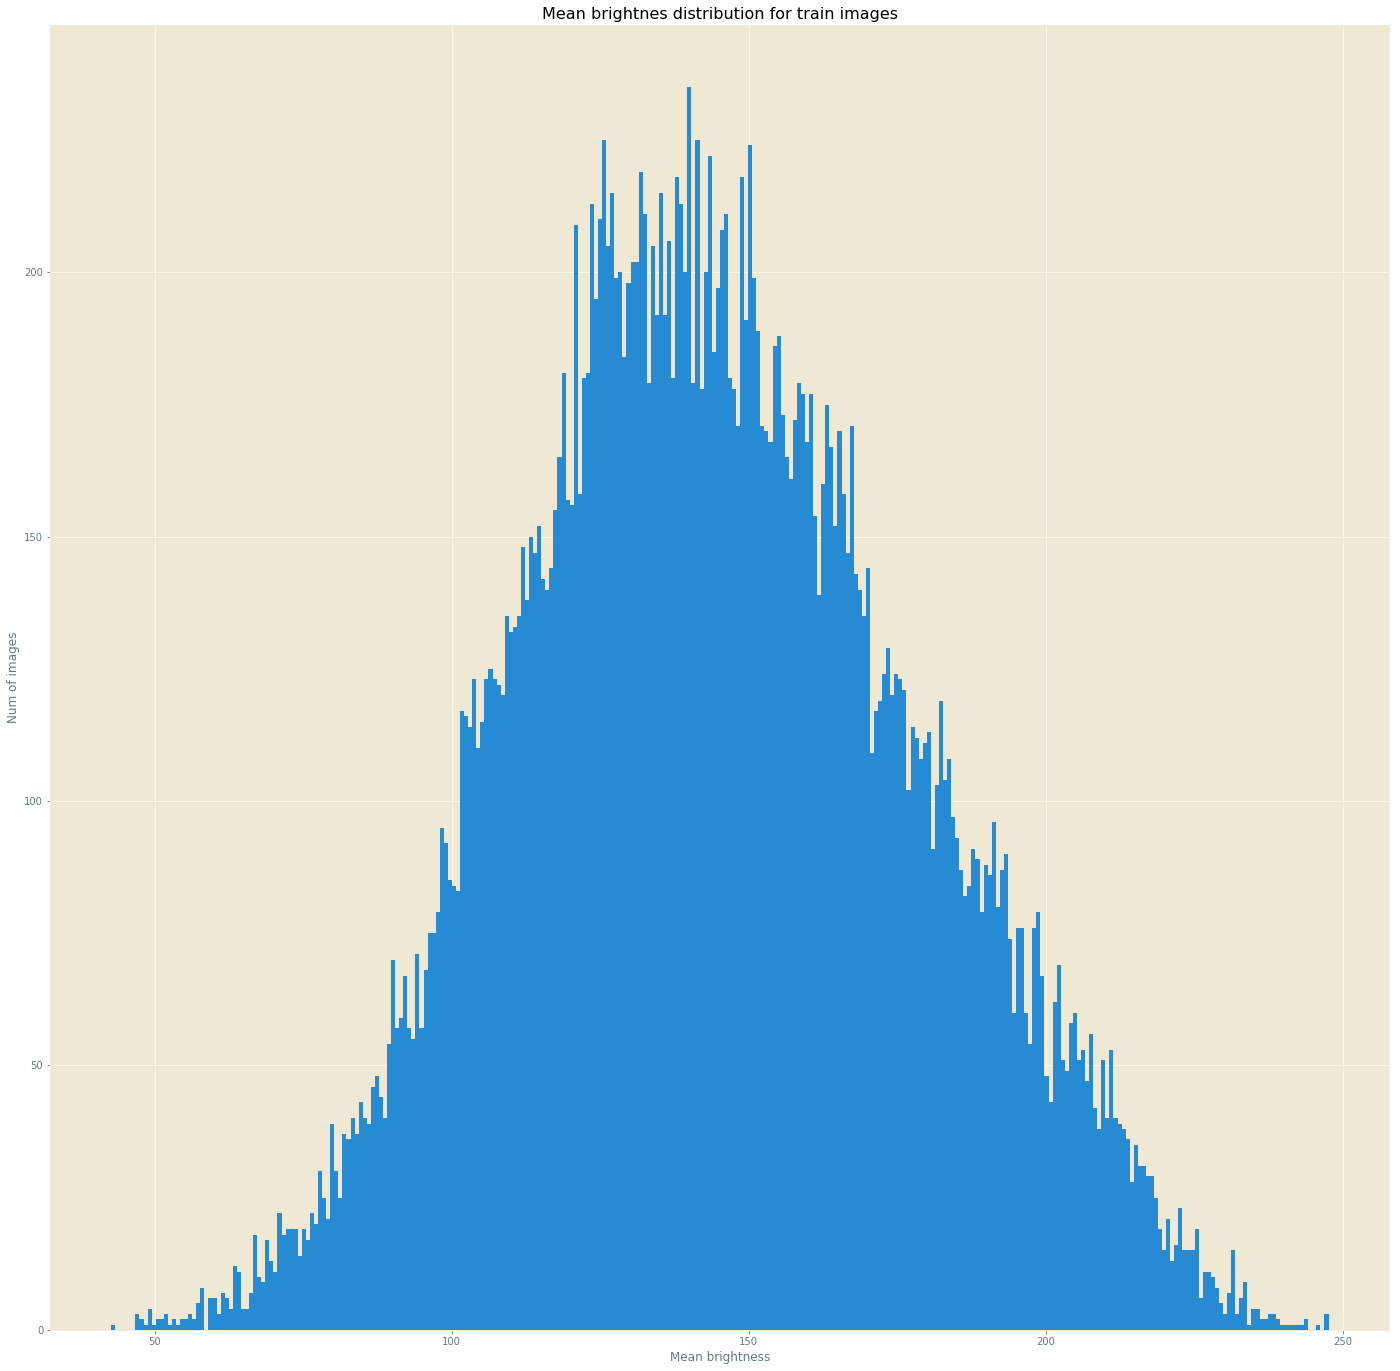

In [83]:
fig = plt.figure(figsize=(24, 24))
ax = fig.add_subplot(111)
ax.hist(whales_train_images_mean_brightness, bins=300)
ax.set_title("Mean brightnes distribution for train images")
#ax.set(title="Mean brightnes distribution for images with chips")
ax.set_xlabel("Mean brightness")
ax.set_ylabel("Num of images")
plt.show()

In [58]:
#random_selected_train_images = random_objects_select(train_images, 9000)

In [59]:
#print(type(random_selected_train_images[0]))
#print(random_selected_train_images[0])

In [60]:
#random_selected_train_images_mean_brightness = [
#    compute_whole_image_mean_brightnes(image) for image in random_selected_train_images
#]

In [61]:
#fig = plt.figure(figsize=(24, 24))
#ax = fig.add_subplot(111)
#ax.hist(random_selected_train_images_mean_brightness, bins=100)
#plt.show()

In [84]:
print(whales_train_images_mean_brightness[0])

80.43945664478153


In [85]:
print((sum(whales_train_images_mean_brightness)) / len(whales_train_images_mean_brightness))

144.7314920318592


In [86]:
print(type(whales_train_images[8].shape))

<class 'tuple'>


In [87]:
whales_train_images_shapes_counter_dict = {}
for image in whales_train_images:
    if image.shape in whales_train_images_shapes_counter_dict:
        whales_train_images_shapes_counter_dict[image.shape] += 1
    else:
        whales_train_images_shapes_counter_dict[image.shape] = 1

In [88]:
len(whales_train_images_shapes_counter_dict)

5803

In [90]:
for key, value in whales_train_images_shapes_counter_dict.items():
    print(key, value)

(631, 1050, 3) 14
(361, 1050, 3) 22
(600, 1050, 3) 1724
(555, 729, 3) 1
(304, 533, 3) 1
(299, 1050, 3) 20
(328, 917, 3) 1
(472, 707, 3) 2
(621, 932, 3) 1
(652, 1000, 3) 112
(266, 720, 3) 1
(351, 818, 3) 1
(571, 1050, 3) 7
(418, 1050, 3) 17
(397, 596, 3) 1
(317, 758, 3) 1
(700, 1050, 3) 3330
(525, 1050, 3) 1303
(538, 1019) 1
(512, 697, 3) 1
(408, 816, 3) 2
(632, 1050, 3) 4
(697, 1050, 3) 25
(207, 634, 3) 1
(600, 1050) 825
(302, 1050, 3) 19
(555, 852, 3) 1
(709, 1050, 3) 8
(500, 700) 667
(674, 1050, 3) 7
(565, 1022, 3) 1
(335, 1050, 3) 27
(331, 1050, 3) 20
(190, 443, 3) 1
(775, 1050, 3) 9
(450, 1050, 3) 1556
(267, 1050, 3) 18
(394, 920, 3) 1
(525, 2700) 15
(692, 1036, 3) 1
(591, 1050, 3) 280
(449, 1050, 3) 45
(412, 1050, 3) 28
(581, 1016, 3) 2
(262, 393, 3) 2
(404, 1050, 3) 25
(311, 1050, 3) 11
(603, 1041, 3) 1
(541, 1050, 3) 9
(610, 915, 3) 1
(224, 1050, 3) 6
(207, 758, 3) 1
(355, 1050, 3) 21
(810, 1050, 3) 3
(773, 1050, 3) 4
(785, 1050, 3) 3
(451, 1050, 3) 47
(163, 1050, 3) 1
(240, 105

(588, 1050) 1
(517, 1050, 3) 10
(583, 1050, 3) 6
(875, 1050, 3) 2
(603, 1050) 12
(664, 930, 3) 1
(566, 1050) 1
(431, 754, 3) 1
(788, 1050, 3) 21
(276, 1050, 3) 10
(399, 1050, 3) 19
(237, 552, 3) 2
(438, 1023, 3) 2
(443, 622, 3) 1
(339, 1050, 3) 22
(271, 679, 3) 1
(449, 786) 1
(418, 732, 3) 1
(541, 705, 3) 1
(565, 901) 1
(224, 746, 3) 1
(315, 630, 3) 1
(526, 885, 3) 1
(532, 1050, 3) 8
(330, 592, 3) 1
(587, 2155) 1
(590, 1033, 3) 1
(260, 1050, 3) 14
(548, 994) 1
(710, 1016) 1
(671, 1050, 3) 7
(779, 1050, 3) 6
(136, 1050, 3) 3
(475, 830, 3) 1
(464, 812, 3) 1
(344, 804, 3) 1
(479, 1009, 3) 1
(348, 765, 3) 1
(391, 700) 2
(399, 700) 6
(891, 1050, 3) 1
(477, 1366) 1
(282, 640, 3) 2
(703, 912, 3) 1
(682, 1023, 3) 2
(587, 884, 3) 1
(605, 1050) 4
(174, 405, 3) 1
(273, 639, 3) 1
(489, 856) 1
(287, 601, 3) 1
(203, 855, 3) 1
(430, 700) 1
(486, 2346) 1
(225, 1050, 3) 10
(405, 700) 6
(368, 552, 3) 2
(504, 834, 3) 1
(283, 850, 3) 1
(457, 1050, 3) 11
(370, 648, 3) 2
(841, 1050, 3) 3
(494, 865, 3) 1
(63

(428, 750, 3) 2
(421, 736, 3) 1
(579, 868, 3) 1
(476, 1050, 3) 11
(561, 1050, 3) 7
(383, 574, 3) 1
(294, 990, 3) 1
(452, 678, 3) 1
(518, 885, 3) 1
(361, 842, 3) 1
(727, 1058) 1
(177, 421, 3) 1
(539, 717, 3) 1
(455, 1000) 1
(236, 670, 3) 1
(530, 850) 1
(286, 666, 3) 2
(302, 725, 3) 1
(574, 1050, 3) 8
(343, 771, 3) 1
(347, 844, 3) 1
(351, 526, 3) 2
(400, 711) 1
(97, 226, 3) 1
(642, 963, 3) 6
(744, 1050, 3) 1
(426, 813, 3) 1
(197, 536, 3) 1
(165, 600, 3) 1
(376, 877, 3) 2
(324, 757, 3) 1
(607, 2060) 1
(521, 912, 3) 3
(391, 912, 3) 2
(359, 837, 3) 3
(360, 885, 3) 1
(686, 1050, 3) 6
(418, 736, 3) 1
(385, 674, 3) 3
(385, 667) 1
(830, 1050, 3) 4
(763, 1050, 3) 12
(543, 1020) 1
(376, 659, 3) 1
(716, 1050, 3) 7
(309, 722, 3) 2
(364, 850, 3) 1
(363, 634, 3) 1
(466, 940, 3) 1
(547, 1019) 1
(700, 3501) 1
(602, 903, 3) 1
(579, 1050, 3) 7
(102, 365, 3) 1
(770, 3090) 1
(604, 865, 3) 1
(637, 1050, 3) 4
(298, 738, 3) 1
(382, 573, 3) 1
(260, 665, 3) 1
(306, 714, 3) 1
(350, 612, 3) 2
(505, 1033, 3) 1
(35

(203, 1050, 3) 4
(420, 840, 3) 2
(307, 570, 3) 1
(747, 1063) 1
(245, 882, 3) 1
(612, 918, 3) 1
(199, 1050, 3) 3
(410, 2296) 1
(399, 698, 3) 2
(370, 774, 3) 1
(357, 536, 3) 2
(538, 943, 3) 1
(444, 888, 3) 2
(264, 616, 3) 2
(624, 946, 3) 1
(534, 801, 3) 4
(330, 983, 3) 1
(525, 875) 1
(517, 795, 3) 1
(449, 1047, 3) 1
(970, 1050, 3) 1
(761, 1050, 3) 5
(973, 1050, 3) 1
(350, 817, 3) 3
(449, 1048, 3) 1
(355, 976) 1
(308, 448, 3) 1
(268, 932, 3) 1
(388, 875, 3) 1
(295, 688, 3) 2
(238, 786, 3) 1
(309, 618, 3) 1
(483, 966, 3) 1
(378, 881, 3) 3
(588, 885, 3) 8
(186, 371, 3) 1
(465, 975, 3) 1
(492, 984, 3) 4
(577, 1010) 3
(836, 1050, 3) 2
(781, 1050, 3) 6
(632, 2858) 1
(827, 1050, 3) 2
(529, 883, 3) 1
(627, 1050, 3) 4
(100, 223) 1
(140, 496, 3) 1
(240, 480, 3) 3
(167, 281, 3) 1
(565, 990, 3) 1
(197, 513, 3) 1
(239, 616, 3) 1
(475, 840) 2
(175, 409, 3) 1
(449, 770, 3) 1
(659, 1384) 1
(463, 875) 1
(334, 656) 1
(104, 367, 3) 1
(568, 1038) 1
(507, 997) 1
(374, 561, 3) 1
(350, 860, 3) 1
(310, 724, 3) 

(279, 763, 3) 1
(379, 640, 3) 2
(704, 866, 3) 1
(270, 661, 3) 1
(689, 1050) 1
(473, 828, 3) 1
(872, 3240) 1
(158, 954, 3) 1
(211, 317, 3) 1
(586, 1272) 1
(789, 1050, 3) 1
(315, 735, 3) 1
(452, 792, 3) 1
(570, 881, 3) 1
(597, 1044) 1
(309, 541, 3) 1
(253, 696, 3) 1
(249, 581, 3) 1
(662, 997, 3) 1
(509, 676, 3) 1
(356, 623, 3) 2
(510, 765, 3) 2
(361, 659) 1
(267, 733, 3) 1
(836, 1764) 1
(608, 700, 3) 1
(382, 907, 3) 1
(288, 529, 3) 1
(557, 1050, 3) 7
(295, 973, 3) 1
(147, 1050, 3) 1
(377, 570, 3) 1
(685, 1028, 3) 1
(268, 605, 3) 1
(220, 743, 3) 1
(371, 947, 3) 1
(219, 689, 3) 1
(408, 951, 3) 2
(358, 625, 3) 1
(257, 386, 3) 1
(210, 553, 3) 1
(247, 521, 3) 1
(548, 822, 3) 3
(316, 543, 3) 1
(340, 567, 3) 1
(613, 960, 3) 1
(462, 924, 3) 2
(408, 714, 3) 2
(121, 282, 3) 1
(614, 921, 3) 2
(488, 944, 3) 1
(357, 1536) 1
(542, 813, 3) 2
(688, 898, 3) 1
(693, 1047) 1
(445, 1037, 3) 1
(251, 514, 3) 1
(360, 540, 3) 1
(368, 1010, 3) 1
(273, 796, 3) 1
(111, 271, 3) 1
(310, 620, 3) 1
(213, 405, 3) 1
(35

(547, 922) 1
(242, 564, 3) 2
(195, 454, 3) 1
(296, 640, 3) 1
(700, 2160) 1
(720, 955, 3) 1
(364, 1719) 1
(168, 395, 3) 1
(545, 1001) 1
(607, 1054) 1
(549, 824, 3) 2
(449, 1050) 1
(822, 1050, 3) 3
(403, 604, 3) 2
(409, 880, 3) 1
(499, 1016) 1
(364, 687) 1
(365, 853, 3) 1
(345, 974, 3) 1
(578, 1003) 1
(430, 722) 1
(688, 1031, 3) 1
(555, 883, 3) 1
(271, 497, 3) 1
(498, 872, 3) 1
(313, 731, 3) 1
(302, 638, 3) 1
(550, 826, 3) 1
(317, 609, 3) 1
(75, 175, 3) 1
(240, 640, 3) 1
(529, 2700) 1
(527, 739, 3) 1
(878, 878, 3) 1
(783, 1050, 3) 2
(208, 452, 3) 1
(452, 992) 1
(581, 1027, 3) 1
(683, 884, 3) 1
(405, 708, 3) 2
(523, 1010) 1
(800, 1031, 3) 1
(696, 973, 3) 1
(631, 946, 3) 1
(497, 745, 3) 2
(615, 931, 3) 1
(542, 1020) 1
(597, 1050) 4
(519, 909, 3) 2
(224, 640, 3) 1
(167, 756, 3) 1
(497, 869, 3) 2
(490, 857, 3) 3
(406, 709, 3) 2
(598, 1019) 1
(343, 699, 3) 1
(515, 1032, 3) 1
(595, 1050) 3
(427, 998) 1
(414, 725, 3) 1
(597, 896, 3) 2
(220, 386, 3) 1
(594, 852, 3) 1
(374, 874, 3) 1
(440, 982, 3

(124, 260, 3) 1
(717, 2825) 1
(184, 614, 3) 1
(544, 953, 3) 1
(381, 667, 3) 2
(325, 931, 3) 1
(535, 936, 3) 1
(595, 795, 3) 1
(428, 896) 1
(228, 579, 3) 1
(120, 237, 3) 1
(191, 639, 3) 1
(444, 1035, 3) 1
(446, 1040, 3) 2
(294, 687, 3) 1
(369, 646, 3) 1
(446, 781, 3) 1
(450, 864, 3) 1
(645, 927, 3) 1
(390, 693) 1
(728, 1076) 1
(237, 829, 3) 1
(170, 290, 3) 1
(588, 1005, 3) 1
(615, 1025, 3) 1
(503, 1019) 1
(168, 604, 3) 1
(699, 871, 3) 1
(264, 1504) 1
(160, 409, 3) 1
(177, 788, 3) 1
(492, 861, 3) 1
(186, 279, 3) 1
(380, 665, 3) 2
(278, 556, 3) 1
(557, 835, 3) 2
(590, 4565) 1
(559, 1000) 1
(292, 673) 1
(228, 534, 3) 1
(393, 687, 3) 1
(661, 1025, 3) 1
(497, 901, 3) 1
(399, 592, 3) 1
(470, 705, 3) 1
(414, 1045, 3) 1
(439, 1024, 3) 1
(419, 977, 3) 1
(514, 898, 3) 1
(599, 960, 3) 1
(339, 593, 3) 1
(290, 780, 3) 1
(337, 786, 3) 2
(81, 188, 3) 1
(679, 1019, 3) 2
(268, 470, 3) 1
(134, 286, 3) 1
(474, 883, 3) 1
(871, 1050, 3) 1
(369, 999, 3) 1
(219, 557) 1
(656, 968) 1
(253, 573, 3) 1
(804, 1050,

(449, 717, 3) 1
(176, 1050, 3) 1
(277, 592, 3) 1
(169, 872, 3) 1
(558, 978, 3) 1
(423, 666) 1
(552, 817, 3) 1
(177, 739, 3) 1
(551, 734, 3) 1
(644, 966, 3) 1
(258, 932, 3) 1
(488, 851, 3) 1
(222, 657, 3) 1
(463, 925, 3) 1
(342, 572, 3) 1
(685, 1520) 1
(307, 640, 3) 1
(391, 913, 3) 1
(416, 773, 3) 1
(407, 633, 3) 1
(292, 584, 3) 1
(307, 718, 3) 1
(548, 821, 3) 1
(305, 902, 3) 1
(727, 2665) 1
(288, 1553) 1
(185, 862, 3) 1
(445, 1040, 3) 1
(601, 821, 3) 1
(334, 607, 3) 1
(694, 4570) 1
(536, 2795) 1
(336, 1456) 1
(219, 546, 3) 1
(420, 981, 3) 1
(258, 651, 3) 1
(202, 936, 3) 1
(545, 953) 1
(454, 832, 3) 1
(555, 1505) 1
(188, 423, 3) 1
(580, 1016, 3) 1
(239, 558, 3) 1
(568, 919) 1
(378, 696) 1
(188, 940, 3) 1
(651, 855, 3) 1
(333, 514, 3) 1
(547, 958, 3) 1
(366, 620) 1
(333, 665) 1
(529, 912, 3) 1
(530, 927) 1
(159, 481, 3) 1
(305, 1004, 3) 1
(482, 844) 1
(745, 1050) 1
(415, 727, 3) 1
(1013, 1014, 3) 1
(278, 485, 3) 1
(280, 640, 3) 1
(147, 305, 3) 1
(510, 1001) 1
(249, 436, 3) 1
(242, 838, 3

In [91]:
whales_train_images_shapes_len_dict = {1: 0, 2: 0, 3: 0, 4: 0}
for key in whales_train_images_shapes_counter_dict.keys():
    whales_train_images_shapes_len_dict[len(key)] += 1

In [92]:
print(whales_train_images_shapes_len_dict)

{1: 0, 2: 1185, 3: 4618, 4: 0}


In [93]:
whales_train_images_color_channels_counter_dict = {1: 0, 3: 0}
for image in whales_train_images:
    if len(image.shape) == 2:
        whales_train_images_color_channels_counter_dict[1] += 1
    elif len(image.shape) == 3 and image.shape[2] == 3:
        whales_train_images_color_channels_counter_dict[3] += 1

In [94]:
print(whales_train_images_color_channels_counter_dict)

{1: 3386, 3: 21975}


In [95]:
whales_train_images_color_channels_counter_dict[1] + whales_train_images_color_channels_counter_dict[3] == len(whales_train_images)

True

In [72]:
print(type(whales_train_images))
print(len(whales_train_images))

<class 'list'>
25361


In [ ]:
#whales_train_images_color_channels = [get_image_color_channels(image) for image in whales_train_images]

In [ ]:
ships_train_images_color_channels_modes = compute_images_color_channels_modes(
    ships_train_images_color_channels
)

In [ ]:
ships_train_images_color_channels_modes_collected = collect_modes_and_frequencies(
    ships_train_images_color_channels_modes
)

In [ ]:
ships_train_images_modes_values = ships_train_images_color_channels_modes_collected.keys()
ships_train_images_modes_frequencies = ships_train_images_color_channels_modes_collected.values()

In [ ]:
ships_train_images_modes_values_sorted = sorted(ships_train_images_modes_values)
ships_train_images_modes_frequencies_sorted = []
for mode_value in ships_train_images_modes_values_sorted:
    ships_train_images_modes_frequencies_sorted.append(ships_train_images_color_channels_modes_collected[mode_value])

In [ ]:
fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(111)
ax.hist(ships_train_images_modes_values, bins=200)
plt.show()

In [ ]:
fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(111)
ax.hist(ships_train_images_modes_modes_frequencies, bins=70)
plt.show()

In [ ]:
fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(111)
ax.set_title("No ships train images brighthess modes values/modes frequencies")
ax.plot(no_ships_train_images_modes_values_sorted, no_ships_train_images_modes_frequencies_sorted)
#ax.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(111)
ax.set_title("No ships train images brighthess modes values/modes frequencies")
ax.plot(ships_train_images_modes_values_sorted, ships_train_images_modes_frequencies_sorted)
plt.show()

In [ ]:
print(type(ships_train_images_color_channels))
print(len(ships_train_images_color_channels))
print(len(ships_train_images_color_channels[0]))
print(type(ships_train_images_color_channels[0]))
print(ships_train_images_color_channels[0])
print()

In [ ]:
images_list_color_channels_mean_brightness = compute_images_list_color_channels_mean_brightness(
    no_ships_train_images_color_channels
)

In [ ]:
print(type(images_list_color_channels_mean_brightness))
print(images_list_color_channels_mean_brightness[0])

In [ ]:
divided_to_color_channels_images_mean_brightness = divide_color_channels_values(
    images_list_color_channels_mean_brightness    
)

In [ ]:
'''
print(type(divided_to_color_channels_images_mean_brightness))
print(len(divided_to_color_channels_images_mean_brightness))
print(type(divided_to_color_channels_images_mean_brightness[0]))
print(len(divided_to_color_channels_images_mean_brightness[0]))
print(len(divided_to_color_channels_images_mean_brightness[1]))
print(len(divided_to_color_channels_images_mean_brightness[2]))
print(type(divided_to_color_channels_images_mean_brightness[0][0]))
#print(len(divided_to_color_channels_images_mean_brightness[0][0]))
print(divided_to_color_channels_images_mean_brightness[0][0])
print(divided_to_color_channels_images_mean_brightness[1][0])
print(divided_to_color_channels_images_mean_brightness[2][0])
#print(
#    divided_to_color_channels_images_mean_brightness[0],
#    divided_to_color_channels_images_mean_brightness[1],
#    divided_to_color_channels_images_mean_brightness[2]
#)
'''s

In [ ]:
no_ship_images_red_color_channel_mean_brightness = divided_to_color_channels_images_mean_brightness[0]
no_ship_images_yellow_color_channel_mean_brightness = divided_to_color_channels_images_mean_brightness[1]
no_ship_images_blue_color_channel_mean_brightness = divided_to_color_channels_images_mean_brightness[2]

In [ ]:
gathered_no_ship_images_red_color_channel_mean_brightness = gather_objects_and_frequencies(
    no_ship_images_red_color_channel_mean_brightness
)

In [ ]:
gathered_no_ship_images_yellow_color_channel_mean_brightness = gather_objects_and_frequencies(
    no_ship_images_yellow_color_channel_mean_brightness
)

In [ ]:
gathered_no_ship_images_blue_color_channel_mean_brightness = gather_objects_and_frequencies(
    no_ship_images_blue_color_channel_mean_brightness
)

In [ ]:
gathered_no_ship_images_red_color_channel_mean_brightness_sorted = sort_gathered_objects(
    gathered_no_ship_images_red_color_channel_mean_brightness
)

In [ ]:
no_ship_images_red_color_channel_mean_brightness_sorted = gathered_no_ship_images_red_color_channel_mean_brightness_sorted
no_ship_images_red_color_channel_mean_brightness_frequencies_sorted = gathered_no_ship_images_red_color_channel_mean_brightness_sorted

In [ ]:
fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(111)
ax.plot(
    no_ship_images_red_color_channel_mean_brightness_sorted,
    no_ship_images_red_color_channel_mean_brightness_frequencies_sorted,
    color='red',
    label='red',
    lw=2
)
plt.show()

In [ ]:
print(type(gathered_no_ship_images_red_color_channel_mean_brightness))
print(len(gathered_no_ship_images_red_color_channel_mean_brightness))

In [ ]:
print(type(ships_train_images_color_channels_modes))
print(len(ships_train_images_color_channels_modes))

In [ ]:
print(ships_train_images_color_channels_modes[0])

In [ ]:
print(type(ships_train_images_color_channels))
print(len(ships_train_images_color_channels))
print(ships_train_images_color_channels[0])

In [ ]:
no_ships_tr_imgs_clr_ch_modes = [
    compute_color_channels_modes(
        img_clr_ch_modes
    ) for img_clr_ch_modes in no_ships_train_images_color_channels
]

In [ ]:
ships_tr_imgs_clr_ch_modes = [
    compute_color_channels_modes(
        img_clr_ch_modes
    ) for img_clr_ch_modes in ships_train_images_color_channels
]

In [ ]:
print(type(ships_tr_imgs_clr_ch_modes))
print(len(ships_tr_imgs_clr_ch_modes))
print(ships_tr_imgs_clr_ch_modes[0])
print(ships_tr_imgs_clr_ch_modes[1])
print(ships_tr_imgs_clr_ch_modes[2])

In [ ]:
compute_color_channel_mode(ships_train_images_color_channels[0][0])

In [ ]:
#print(type(ships_train_images_color_channels_modes_collected))
#print(len(ships_train_images_color_channels_modes_collected))
#print(ships_train_images_color_channels_modes_collected)

In [ ]:
no_ships_tr_imgs_clr_ch_modes_div = divide_color_channels_values(no_ships_tr_imgs_clr_ch_modes)
ships_tr_imgs_clr_ch_modes_div = divide_color_channels_values(ships_tr_imgs_clr_ch_modes)

In [ ]:
print(type(ships_tr_imgs_clr_ch_modes_div))
print(len(ships_tr_imgs_clr_ch_modes_div))

In [ ]:
no_ships_tr_imgs_clr_ch_modes_red = gather_color_channel_modes_and_frequencies(no_ships_tr_imgs_clr_ch_modes_div[0])
no_ships_tr_imgs_clr_ch_modes_yellow = gather_color_channel_modes_and_frequencies(no_ships_tr_imgs_clr_ch_modes_div[1])
no_ships_tr_imgs_clr_ch_modes_blue = gather_color_channel_modes_and_frequencies(no_ships_tr_imgs_clr_ch_modes_div[2])

In [ ]:
ships_tr_imgs_clr_ch_modes_red = gather_color_channel_modes_and_frequencies(ships_tr_imgs_clr_ch_modes_div[0])
ships_tr_imgs_clr_ch_modes_yellow = gather_color_channel_modes_and_frequencies(ships_tr_imgs_clr_ch_modes_div[1])
ships_tr_imgs_clr_ch_modes_blue = gather_color_channel_modes_and_frequencies(ships_tr_imgs_clr_ch_modes_div[2])

In [ ]:
print(type(ships_tr_imgs_clr_ch_modes_red))
print(len(ships_tr_imgs_clr_ch_modes_red))
print(type(ships_tr_imgs_clr_ch_modes_yellow))
print(len(ships_tr_imgs_clr_ch_modes_yellow))
print(type(ships_tr_imgs_clr_ch_modes_blue))
print(len(ships_tr_imgs_clr_ch_modes_blue))

In [ ]:
#ships_train_images_modes_values_sorted = sorted(ships_train_images_modes_values)
#ships_train_images_modes_frequencies_sorted = []
#for mode_value in ships_train_images_modes_values_sorted:
#    ships_train_images_modes_frequencies_sorted.append(ships_train_images_color_channels_modes_collected[mode_value])

In [ ]:
no_ships_tr_imgs_clr_ch_modes_and_freq_r_sr = sort_gathered_objects(no_ships_tr_imgs_clr_ch_modes_red)
no_ships_tr_imgs_clr_ch_modes_and_freq_y_sr = sort_gathered_objects(no_ships_tr_imgs_clr_ch_modes_yellow)
no_ships_tr_imgs_clr_ch_modes_and_freq_b_sr = sort_gathered_objects(no_ships_tr_imgs_clr_ch_modes_blue)

In [ ]:
ships_tr_imgs_clr_ch_modes_and_freq_r_sr = sort_gathered_objects(ships_tr_imgs_clr_ch_modes_red)
ships_tr_imgs_clr_ch_modes_and_freq_y_sr = sort_gathered_objects(ships_tr_imgs_clr_ch_modes_yellow)
ships_tr_imgs_clr_ch_modes_and_freq_b_sr = sort_gathered_objects(ships_tr_imgs_clr_ch_modes_blue)

In [ ]:
fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(111)
ax.plot(
    no_ships_tr_imgs_clr_ch_modes_and_freq_r_sr[0],
    no_ships_tr_imgs_clr_ch_modes_and_freq_r_sr[1],
    color='red'
)
plt.show()

In [ ]:
fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(111)
ax.plot(
    ships_tr_imgs_clr_ch_modes_and_freq_r_sr[0],
    ships_tr_imgs_clr_ch_modes_and_freq_r_sr[1],
    color='red'
)
plt.show()

In [ ]:
fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(111)
ax.plot(
    no_ships_tr_imgs_clr_ch_modes_and_freq_y_sr[0],
    no_ships_tr_imgs_clr_ch_modes_and_freq_y_sr[1],
    color='yellow'
)
plt.show()

In [ ]:
fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(111)
ax.plot(
    ships_tr_imgs_clr_ch_modes_and_freq_y_sr[0],
    ships_tr_imgs_clr_ch_modes_and_freq_y_sr[1],
    color='yellow'
)
plt.show()

In [ ]:
fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(111)
ax.plot(
    no_ships_tr_imgs_clr_ch_modes_and_freq_b_sr[0],
    no_ships_tr_imgs_clr_ch_modes_and_freq_b_sr[1],
    color='blue'
)
plt.show()

In [ ]:
fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(111)
ax.plot(
    ships_tr_imgs_clr_ch_modes_and_freq_b_sr[0],
    ships_tr_imgs_clr_ch_modes_and_freq_b_sr[1],
    color='blue'
)
plt.show()

In [99]:
group_by_id_train_images_description_df = train_images_description_df.groupby('Id')

In [101]:
example_of_grouped_objects = list(group_by_id_train_images_description_df)[:3]

In [108]:
for grouped_object in example_of_grouped_objects:
    print("\n*******\ntype(grouped_object): ", type(grouped_object))
    print("\ngrouped_object:\n", grouped_object)
    '''
    print("\ntype(grouped_object[0]): {}, type(grouped_object[1]): {}, type(grouped_object[2]): {} \n\n".format(
            type(grouped_object[0]),
            type(grouped_object[1]),
            type(grouped_object[2])
        )
    )
    '''
    print("\ntype(grouped_object[0]): {}, type(grouped_object[1]): {}\n\n".format(
            type(grouped_object[0]),
            type(grouped_object[1])
        )
    )


*******
type(grouped_object):  <class 'tuple'>

grouped_object:
 ('new_whale',                Image         Id
3      00050a15a.jpg  new_whale
4      0005c1ef8.jpg  new_whale
5      0006e997e.jpg  new_whale
7      000f0f2bf.jpg  new_whale
11     001d7450c.jpg  new_whale
12     00200e115.jpg  new_whale
13     00245a598.jpg  new_whale
14     002b4615d.jpg  new_whale
15     002f99f01.jpg  new_whale
18     003795857.jpg  new_whale
19     0041880bf.jpg  new_whale
20     0043da555.jpg  new_whale
22     00464ff65.jpg  new_whale
24     004ae9e26.jpg  new_whale
25     004c0f43b.jpg  new_whale
33     005ce3100.jpg  new_whale
34     00600ce17.jpg  new_whale
38     006506edf.jpg  new_whale
40     006bdc6ff.jpg  new_whale
42     007218187.jpg  new_whale
49     0085064af.jpg  new_whale
50     0085a6bd0.jpg  new_whale
51     00869b59e.jpg  new_whale
55     00917baa4.jpg  new_whale
59     0095fe89c.jpg  new_whale
65     00a46c559.jpg  new_whale
67     00a70e649.jpg  new_whale
69     00aae723d.jpg  ne

In [109]:
count_of_images_with_particular_id = group_by_id_train_images_description_df.count()

In [110]:
type(count_of_images_with_particular_id)

pandas.core.frame.DataFrame

In [111]:
count_of_images_with_particular_id.shape

(5005, 1)

In [112]:
count_of_images_with_particular_id.head()

,Image
Id,
new_whale,9664
w_0003639,1
w_0003c59,1
w_0027efa,10
w_00289b1,2
